# Multi-Channel LDA (MCLDA) - Patient Group Discovery
------

This notebook applies a Multi-Channel Latent Dirichlet Allocation (MCLDA) model to uncover latent health-related groups in a hospital outpatient dataset. The model jointly learns topic distributions from diagnosis codes/text and demographic information.

We build on previous notebooks that explored regression-based modeling and latent group assignments using structured data. This notebook focuses on unsupervised topic modeling to explore potential health group structures in the data.

First the following packages, scripts and data has to be loaded

## import data

In [1]:
import pandas as pd
import numpy as np 
import torch
import os
from itertools import chain
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
import pyro
import pyro.distributions as dist
from pyro.infer import config_enumerate, SVI, TraceEnum_ELBO
from pyro.ops.indexing import Vindex
from pyro.optim import ClippedAdam
from pyro.distributions import constraints
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


experiment_name = "mlda_1.0_10_steps"
save_dir = os.path.join("outputs", experiment_name)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

/Users/KAROLINE/opt/miniconda3/envs/mbml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:

experiment_name = "mlda_1.0_10_steps"
save_dir = os.path.join("outputs", experiment_name)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)


df = pd.read_csv("data/data_summed.csv")
diagnose_df = pd.read_csv("data/diagnosis.csv", sep=";")

df.head()

,Patient ID,Aktionsdiagnosekode,totalDiagnoseKontaktVarighed,antalKontakter,antalDiagnoser,alder,gender,civilStand,distanceToHospitalKM,patientKommune,embedding
0,Z100,DM059,1.65,2,1,51.000000,Kvinde,Gift,0.974812,København,[-4.27692920e-01 2.37161100e-01 1.58154503e-...
1,Z1000004,DG930A,0.32,1,1,32.000000,Mand,Gift,18.368636,Furesø,[ 4.87706453e-01 1.23474568e-01 1.58385143e-...
2,Z1000010,DM511D,6.98,5,2,45.200000,Mand,Gift,2.963563,København,[-4.93736029e-01 -3.90027910e-01 2.75022358e-...
3,Z1000010,DM549,1.43,1,2,45.000000,Mand,Gift,2.963563,København,[-1.95205912e-01 1.46560818e-01 9.29458261e-...
4,Z1000018,DQ253,3.85,3,1,44.666667,Mand,Ugift,66.423650,Næstved,[-2.10352123e-01 5.80621541e-01 4.50560868e-...


## Data Loading and Preprocessing

We begin by loading diagnosis and demographic data for each patient. Diagnoses are preprocessed into tokens, and demographic fields are bucketed and transformed into categorical tokens.

We construct two channels:
- **Diagnosis channel**: preprocessed diagnosis codes and short texts as individual tokens.
- **Demographic channel**: structured fields such as gender, age group, civil status, converted into discrete tokens.


In [3]:
unique_diag_lists = df.groupby("Patient ID")["Aktionsdiagnosekode"].unique()

code = "Aktionsdiagnosekode"
text = "Aktionsdiagnosetekst"
token_dict = {}

for idx, row in diagnose_df.iterrows():
    code_val = row["Aktionsdiagnosekode"]
    text_val = row["Aktionsdiagnosetekst"]
    code_val4 = code_val[:4] if isinstance(code_val, str) and len(code_val) >= 4 else code_val

    text1 = str(code_val4) if pd.notnull(code_val4) else ""
    text2 = str(text_val) if pd.notnull(text_val) else ""
    combined_text = text1 + " " + text2
    token_dict[code_val] = combined_text


# Convert diagnosis codes to full text tokens
diagnosis_per_patient = {
    pid: [token_dict.get(str(code)) for code in codes if str(code) in token_dict]
    for pid, codes in unique_diag_lists.items()
}

age_bins = [0, 5, 18, 25, 35, 45, 55, 65, 75, 80, 85, 90, 99,  float("inf")]
age_labels = [
    "0–5", "6–17", "18–24", "25–34", "35–44", "45–54", "55–65",
    "66–74", "75–80", "81–85", "86–90", "91–99", "100+"
]


df["Age_Group"] = pd.cut(
    df["alder"],
    bins=age_bins,
    labels=age_labels,
    right=True,
    include_lowest=True
)

# Clean and format demographic values
df["gender"] = df["gender"].astype(str).str.strip()
df["civilStand"] = df["civilStand"].astype(str).str.strip()
df["Age_Group"] = df["Age_Group"].astype(str).str.strip()

# Construct context token list
def demographic_tokens(row):
    tokens = []
    if row["gender"]:
        tokens.append(f"Gender_{row['gender']}")
    if row["civilStand"]:
        tokens.append(f"Civilstatus_{row['civilStand']}")
    if row["Age_Group"]:
        tokens.append(f"AgeGroup_{row['Age_Group']}")
    return tokens

df["context"] = df.apply(demographic_tokens, axis=1)

# Drop rows with no context tokens
df = df[df["context"].map(lambda x: len(x) > 0)]

# Group by Patient ID and take the first available context per patient
context_dict = (
    df.groupby("Patient ID")["context"]
    .first()
    .to_dict()
)


# Create patient_df from diagnoses dictionary
patient_df = pd.DataFrame([
    {"patient_id": pid, "diagnoses": diag}
    for pid, diag in diagnosis_per_patient.items()
])

# Create context_df from context_dict
context_df = pd.DataFrame.from_dict(
    {pid: {"context": tokens} for pid, tokens in context_dict.items()},
    orient="index"
)


patient_df["patient_id"] = patient_df["patient_id"].astype(str).str.strip()
context_df.index = context_df.index.astype(str).str.strip()

# Merge into one final dataframe
patient_df = patient_df.set_index("patient_id").join(context_df, how="left").reset_index()

patient_df = patient_df.dropna(subset=["diagnoses", "context"])


# Sample a subset of 100,000 patients for training
patient_df = patient_df.sample(100000, random_state=42)

patient_df.head(10)


,patient_id,diagnoses,context
49689,Z1508161,[DZ08 Kontrolundersøgelse efter operation af k...,"[Gender_Kvinde, Civilstatus_Andet, AgeGroup_75..."
91723,Z1872013,"[DH25 Aldersbetinget grå stær (>=50 år) UNS, D...","[Gender_Mand, Civilstatus_Gift, AgeGroup_75–80]"
230929,Z389990,"[DN94 Primære menstruationssmerter, DZ11 Scree...","[Gender_Kvinde, Civilstatus_Fraskilt, AgeGroup..."
166878,Z2550779,[DZ00 Kontakt mhp. undersøgelse af potentiel o...,"[Gender_Kvinde, Civilstatus_Gift, AgeGroup_45–54]"
14822,Z1126368,[DK07 Lidelse i kæbeled],"[Gender_Kvinde, Civilstatus_Ugift, AgeGroup_25..."
190464,Z3006763,[DH52 Myopi],"[Gender_Mand, Civilstatus_Ugift, AgeGroup_25–34]"
249576,Z4264344,"[DG40 Fokal epilepsi kun med simple anfald, DR...","[Gender_Mand, Civilstatus_Ugift, AgeGroup_18–24]"
24658,Z1212682,[DG58 Neuropati samtidigt i flere enkelte nerver],"[Gender_Kvinde, Civilstatus_Fraskilt, AgeGroup..."
184974,Z286000,[DM47 Anden spondylose med radikulopati],"[Gender_Kvinde, Civilstatus_Gift, AgeGroup_45–54]"
130569,Z2202519,[DI72 Aneurisme på arteria iliaca],"[Gender_Mand, Civilstatus_Andet, AgeGroup_75–80]"


It is now clear that each row represents a unique patient, with two distinct channels: one for diagnoses - potentially multiple, capturing comorbidities - and one for context, including demographic attributes.

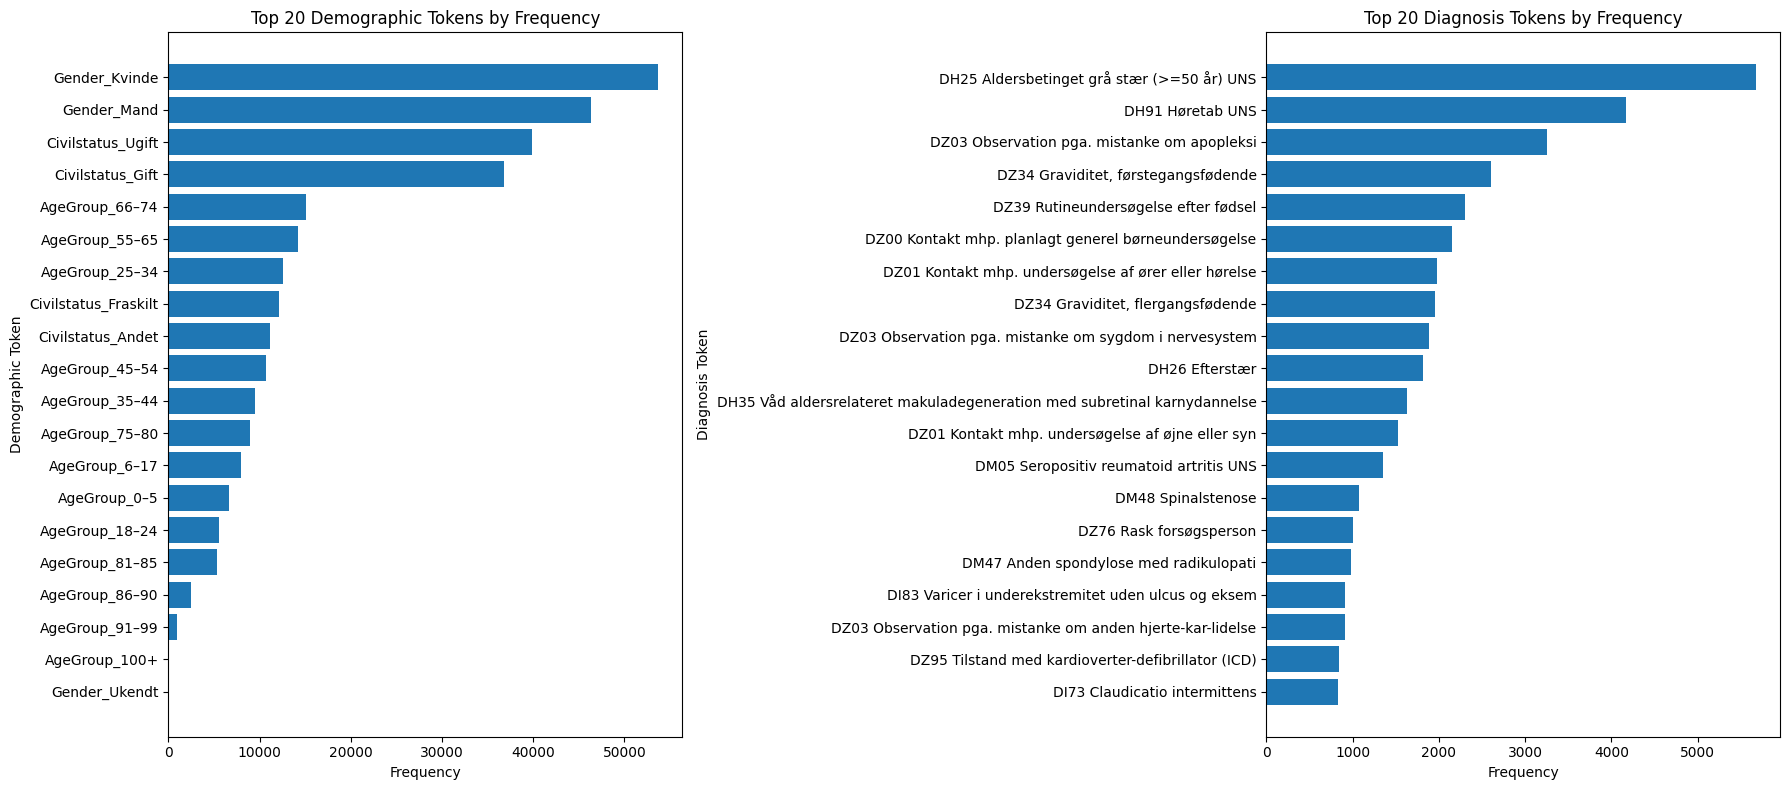

In [4]:
# visual representation of the top demographic tokens
# Flatten and count demographic tokens
flat_demo_tokens = [token for row in patient_df["context"] for token in row]
demo_token_counts = Counter(flat_demo_tokens)
top_demo_tokens = demo_token_counts.most_common(20)
demo_tokens, demo_counts = zip(*top_demo_tokens)

# Flatten and count diagnosis tokens
flat_diag_tokens = [token for row in patient_df["diagnoses"] for token in row]
diag_token_counts = Counter(flat_diag_tokens)
top_diag_tokens = diag_token_counts.most_common(20)
diag_tokens, diag_counts = zip(*top_diag_tokens)

# Plot side by side, horizontal bars
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

axs[0].barh(demo_tokens[::-1], demo_counts[::-1])
axs[0].set_title("Top 20 Demographic Tokens by Frequency")
axs[0].set_xlabel("Frequency")
axs[0].set_ylabel("Demographic Token")

axs[1].barh(diag_tokens[::-1], diag_counts[::-1])
axs[1].set_title("Top 20 Diagnosis Tokens by Frequency")
axs[1].set_xlabel("Frequency")
axs[1].set_ylabel("Diagnosis Token")

plt.tight_layout()
plt.show()

The plot shows that the most common demographic tokens are Gender_Kvinde, Gender_Mand, and Civilstatus_Ugift, reflecting the general structure of the patient population. On the diagnosis side, frequent tokens include age-related conditions like DH25 Aldersbetinget grå stær and DH91 Høretab, as well as routine checkups such as DZ03 Observation.

### Create Vocabularies for the model

For each patient, we start with two lists of tokens:

- patient_df["diagnoses"]: diagnosis tokens assigned to the patient
- patient_df["context"]: demographic tokens.

The below code then:
- Builds vocabularies (diag_vocab and context_vocab) mapping each unique token to an integer ID
- Converts each patient's token list into a sequence of indices using the vocabularies
- Pads all sequences to the same length and creates corresponding masks
- Wraps the processed data into a PyTorch DataLoader for batch-wise training of the MCLDA model

In [6]:


# Diagnosis vocabulary
diag_vocab = {token: idx for idx, token in enumerate(set(chain.from_iterable(patient_df["diagnoses"])))}

# Context vocabulary
context_vocab = {token: idx for idx, token in enumerate(set(chain.from_iterable(patient_df["context"])))}

# Convert tokens to indices
def tokens_to_indices(tokens, vocab):
    return torch.tensor([vocab[token] for token in tokens if token in vocab], dtype=torch.long)

patient_records_indexed = [tokens_to_indices(tokens, diag_vocab) for tokens in patient_df["diagnoses"]]
context_dict_indexed    = [tokens_to_indices(tokens, context_vocab) for tokens in patient_df["context"]]

# padding and masking

PAD_IDX = 0  

def pad_and_mask(sequences, pad_value=PAD_IDX):
    padded = pad_sequence(sequences, batch_first=True, padding_value=pad_value)
    mask = (padded != pad_value)
    return padded, mask


x_tokens, x_mask = pad_and_mask(patient_records_indexed)
d_tokens, d_mask = pad_and_mask(context_dict_indexed)

# Create dataset and DataLoader
dataset = TensorDataset(x_tokens, d_tokens, x_mask, d_mask)
dataloader = DataLoader(dataset, batch_size=200, shuffle=True, drop_last=True)



In [7]:
#display the top vocabulary tokens for diagnosis and context by the frequency of their occurrence
print("Diagnosis Vocabulary and their idx (first 10):")
for token, idx in list(diag_vocab.items())[:10]:
    print(f"{token}: {idx}")
print("\nContext Vocabulary and their idx (first 10):")
for token, idx in list(context_vocab.items())[:10]:
    print(f"{token}: {idx}")

Diagnosis Vocabulary and their idx (first 10):
DJ94 Anden sygdom i lungehinder: 0
DC79 Fjernmetastase i binyre: 1
DT83 Mekanisk komplikation til urinvejskateterisering: 2
DS33 Traumatisk ruptur af symfysen: 3
DQ66 Platfod UNS: 4
DH16 Keratitis forårsaget af Herpes Simplex virus: 5
DS68 Traumatisk amputation af 4. finger: 6
DG71 Recessiv myotonia congenita: 7
DR11 Opkastning: 8
DC81 Klassisk Hodgkin lymfom med nodulær sklerose: 9

Context Vocabulary and their idx (first 10):
AgeGroup_100+: 0
Gender_Ukendt: 1
AgeGroup_91–99: 2
AgeGroup_35–44: 3
AgeGroup_0–5: 4
AgeGroup_18–24: 5
Civilstatus_Gift: 6
Civilstatus_Ugift: 7
Civilstatus_Fraskilt: 8
Civilstatus_Andet: 9


### Multiple-channel latent Dirichlet allocation (MCLDA)
The goal of this model is to uncover hidden patient groups that explain co-occurring patterns in diagnoses and demographics.
We define the number of latent groups (topics) to learn and configure the MCLDA model with:
- Shared group distribution per patient
- Separate topic distributions per channel

### Generative Process

1. For each group $g \in G$:
    - Draw diagnosis-topic distribution: $\phi^{\text{diag}}_g \sim \text{Dirichlet}(\delta^{\text{diag}})$  
    - Draw demographic-topic distribution: $\phi^{\text{demo}}_g \sim \text{Dirichlet}(\delta^{\text{demo}})$

2. For each patient $p \in P$:
    - Draw group proportions: $\theta_p \sim \text{Dirichlet}(\alpha)$

    - For each diagnosis token $n = 1, \dots, N^{\text{diag}}_p$:
        - Draw group assignment: $g^{\text{diag}}_{n,p} \sim \text{Categorical}(\theta_p)$  
        - Draw diagnosis token: $w^{\text{diag}}_{n,p} \sim \text{Categorical}(\phi^{\text{diag}}_g)$

    - For each demographic token $n = 1, \dots, N^{\text{demo}}_p$:
        - Draw group assignment: $g^{\text{demo}}_{n,p} \sim \text{Categorical}(\theta_p)$  
        - Draw demographic token: $w^{\text{demo}}_{n,p} \sim \text{Categorical}(\phi^{\text{demo}}_g)$



In [ ]:
#in below code x refers to diagnosis tokens and d refers to demographic tokens and z refers to the latent topic assignments for each token per patient.
@config_enumerate(default="parallel")
def model(x_tokens, d_tokens, x_mask, d_mask,
          num_groups, num_diag_tokens, num_demo_tokens,
          device):

    x_tokens = x_tokens.to(device)
    d_tokens = d_tokens.to(device)
    x_mask = x_mask.to(device)
    d_mask = d_mask.to(device)

    P, Nx = x_tokens.shape
    _, Nd = d_tokens.shape

    # prior parameters
    alpha = torch.ones(num_groups, device=device) / num_groups 
    delta_x = torch.ones(num_diag_tokens, device=device) / num_diag_tokens
    delta_d = 0.1 * torch.ones(num_demo_tokens, device=device) / num_demo_tokens

    
    # Topic-word distributions (phi)
    with pyro.plate("health_groups", num_groups):
        phi_x = pyro.sample("phi_x", dist.Dirichlet(delta_x))
        phi_d = pyro.sample("phi_d", dist.Dirichlet(delta_d))

    # Per-patient topic proportions 
    with pyro.plate("patients", P):
        theta = pyro.sample("theta", dist.Dirichlet(alpha))  # [P, K]

        # DIAGNOSIS TOKENS
        with pyro.plate("x_tokens", Nx):
            z_x = pyro.sample("z_x", dist.Categorical(theta))  # [P, Nx]
            with pyro.poutine.mask(mask=x_mask.permute(1, 0)):  # [Nx, B]
                probs_x = Vindex(phi_x)[z_x]  # [P, Nx, Vx]
                pyro.sample("w_x", dist.Categorical(probs=probs_x), obs=x_tokens.permute(1, 0))  # [Nx, P]

        # DEMOGRAPHIC TOKENS
        with pyro.plate("d_tokens", Nd):
            z_d = pyro.sample("z_d", dist.Categorical(theta))  # [P, Nd]
            with pyro.poutine.mask(mask=d_mask.permute(1, 0)):  # [Nd, P]
                probs_d = Vindex(phi_d)[z_d]  # [P, Nd, Vd]
                pyro.sample("w_d", dist.Categorical(probs=probs_d), obs=d_tokens.permute(1, 0))  # [Nd, P]



The model is now trained using Stochastical Variational Inference (SVI). 

In [ ]:


def guide(x_tokens, d_tokens, x_mask, d_mask,
          num_groups, num_diag_tokens, num_demo_tokens,
          device):

    
    x_tokens = x_tokens.to(device)
    d_tokens = d_tokens.to(device)
    x_mask = x_mask.to(device)
    d_mask = d_mask.to(device)

    P = x_tokens.shape[0]

    # Topic-word distributions (phi) - global
    phi_x_posterior = pyro.param("phi_x_posterior",
                                 torch.ones(num_groups, num_diag_tokens, device=device),
                                 constraint=constraints.simplex)
    phi_d_posterior = pyro.param("phi_d_posterior",
                                 torch.ones(num_groups, num_demo_tokens, device=device),
                                 constraint=constraints.simplex)

    with pyro.plate("health_groups", num_groups):
        pyro.sample("phi_x", dist.Dirichlet(phi_x_posterior))
        pyro.sample("phi_d", dist.Dirichlet(phi_d_posterior))

    # Patient topic distributions (theta)
    theta_posterior = pyro.param("theta_posterior",
                                 0.1 * torch.ones(P, num_groups, device=device),
                                 constraint=constraints.positive)

    with pyro.plate("patients", P):
        pyro.sample("theta", dist.Dirichlet(theta_posterior))


In [12]:
pyro.clear_param_store()

optimizer = ClippedAdam({"lr": 1e-4})
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=2))


num_groups = 20
num_diag_tokens = len(diag_vocab)
num_demo_tokens = len(context_vocab)
num_steps = 10
losses = []

# Training loop with minibatching
for step in range(num_steps):
    total_loss = 0
    for x_batch, d_batch, x_mask, d_mask in dataloader:

        torch.cuda.empty_cache()

        x_batch = x_batch.to(device)
        d_batch = d_batch.to(device)
        x_mask = x_mask.to(device)
        d_mask = d_mask.to(device)
        loss = svi.step(x_batch, d_batch, x_mask, d_mask,
                        num_groups, num_diag_tokens, num_demo_tokens, device)
        total_loss += loss
        
    losses.append(total_loss)
    torch.cuda.empty_cache()
    
    print(f"[Step {step}] ELBO Loss: {total_loss:.2f}")
    

gc.collect()
torch.cuda.empty_cache()

[Step 0] ELBO Loss: 4364676.39
[Step 1] ELBO Loss: 3981077.11
[Step 2] ELBO Loss: 3308419.91
[Step 3] ELBO Loss: 2355665.34
[Step 4] ELBO Loss: 1223873.21
[Step 5] ELBO Loss: -125415.97
[Step 6] ELBO Loss: -1619335.05
[Step 7] ELBO Loss: -3257465.87
[Step 8] ELBO Loss: -5025352.74
[Step 9] ELBO Loss: -6906715.85


### Inspecting model parameters

In [15]:
#load the trained model
pyro.get_param_store().load(os.path.join(save_dir, "model_params_10.pt"))
loaded_params = torch.load(os.path.join(save_dir, "model_params_10.pt"), map_location=torch.device(device))
for name, param in loaded_params.items():
    pyro.param(name, param.to(device))


AssertionError: malformed ParamStore keys dict_keys(['phi_x_posterior', 'phi_d_posterior', 'theta_posterior'])

In [10]:
num_steps = len(losses)

# loss plotting
def plot_loss(losses):
    plt.figure(figsize=(6, 4))
    plt.plot(losses)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.yscale("log")
    plt.grid()
    plt.savefig(os.path.join(save_dir, f"loss_plot_{num_groups}groups_{10000}samples_{num_steps}steps.pdf"))
    plt.show()


plot_loss(losses)

NameError: name 'losses' is not defined

In [16]:


def save_model(svi, model_path="model_params.pt"):
    """
    Save the model parameters from an SVI object.

    Args:
        svi (pyro.infer.SVI): The SVI object containing the trained model.
        model_path (str): Path to save the model parameters.
    """
    pyro_params = {
        name: pyro.param(name).detach().cpu()
        for name in pyro.get_param_store().keys()
    }
    torch.save(pyro_params, model_path)
    print(f"Model parameters saved to {model_path}")

num_steps = 60  # Number of steps for which the model was trained
model_path = os.path.join(save_dir, f"model_params_{10}.pt")
save_model(svi, model_path=model_path)

Model parameters saved to outputs\mlda_1.0_10_steps\model_params_10.pt


In [22]:


def plot_top_tokens(phi_matrix, vocab_inv, topic_idx, top_k=10, title_prefix="Topic", label="Token"):
    
    topic_dist = phi_matrix[topic_idx]  # [vocab_size]
    topk_indices = torch.topk(topic_dist, top_k).indices
    topk_tokens = [vocab_inv[i.item()] for i in topk_indices]
    topk_probs = topic_dist[topk_indices].detach().cpu().numpy()

    plt.figure(figsize=(8, 4))
    plt.barh(topk_tokens[::-1], topk_probs[::-1])
    plt.xlabel("Probability")
    plt.ylabel(label)
    plt.title(f"{title_prefix} {topic_idx} – Top {top_k} {label}s")
    plt.tight_layout()
    plt.show()


In [25]:
def plot_top_demographic_categories(phi_d, inv_context_vocab, topic_idx, title_prefix="Demographic Topic"):
    topic_dist = phi_d[topic_idx].detach().cpu()
    
   
    token_labels = [inv_context_vocab[i] for i in range(len(inv_context_vocab))]
    
    
    gender_tokens = [(label, prob) for label, prob in zip(token_labels, topic_dist) if "Gender_" in label]
    age_tokens = [(label, prob) for label, prob in zip(token_labels, topic_dist) if "AgeGroup_" in label]
    civil_tokens = [(label, prob) for label, prob in zip(token_labels, topic_dist) if "Civilstatus_" in label]

    
    top_gender = max(gender_tokens, key=lambda x: x[1]) if gender_tokens else ("None", 0.0)
    top_age = max(age_tokens, key=lambda x: x[1]) if age_tokens else ("None", 0.0)
    top_civil = max(civil_tokens, key=lambda x: x[1]) if civil_tokens else ("None", 0.0)

    labels = [top_gender[0], top_civil[0], top_age[0]]
    probs = [top_gender[1], top_civil[1], top_age[1]]

    
    plt.figure(figsize=(8, 4))
    plt.barh(labels[::-1], [p.item() for p in probs[::-1]])  
    plt.xlabel("Probability")
    plt.title(f"{title_prefix} {topic_idx} – Top Demographic Attributes")
    plt.tight_layout()
    plt.show()

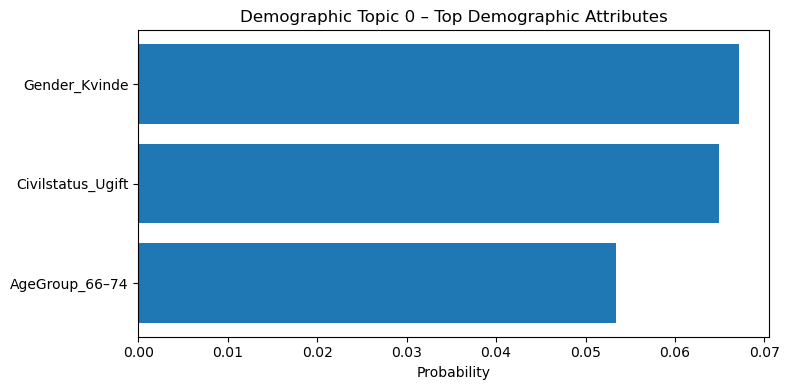

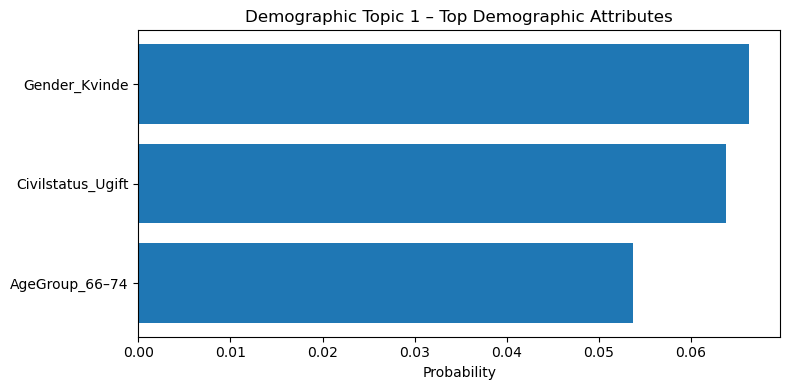

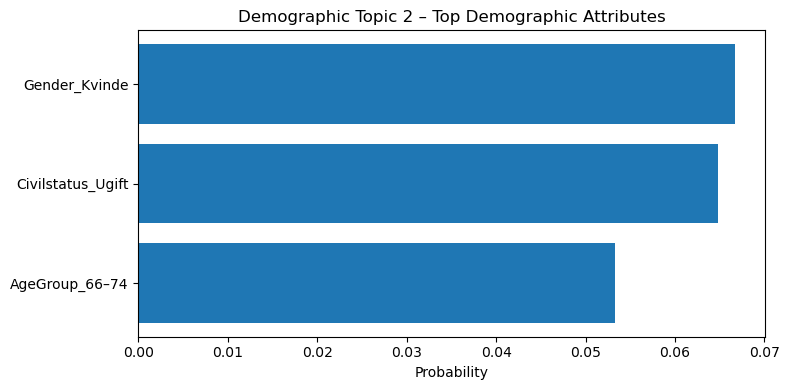

In [26]:
phi_x = pyro.get_param_store().get_param("phi_x_posterior")  
phi_d = pyro.get_param_store().get_param("phi_d_posterior")  


num_topics_to_plot =3
inv_context_vocab = {idx: token for token, idx in context_vocab.items()}
for i in range(num_topics_to_plot):
    plot_top_demographic_categories(phi_d, inv_context_vocab,i, title_prefix="Demographic Topic")

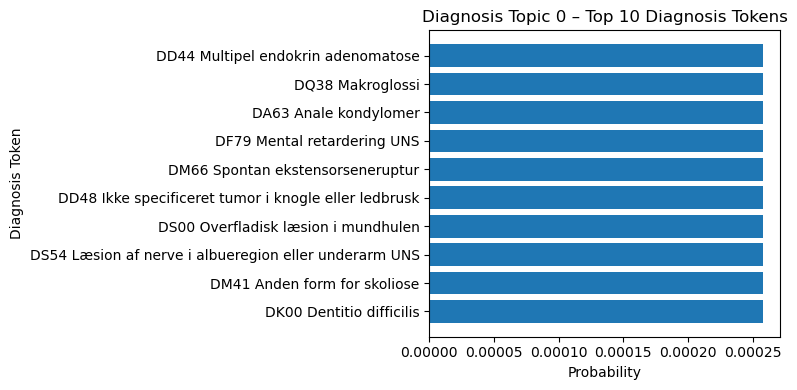

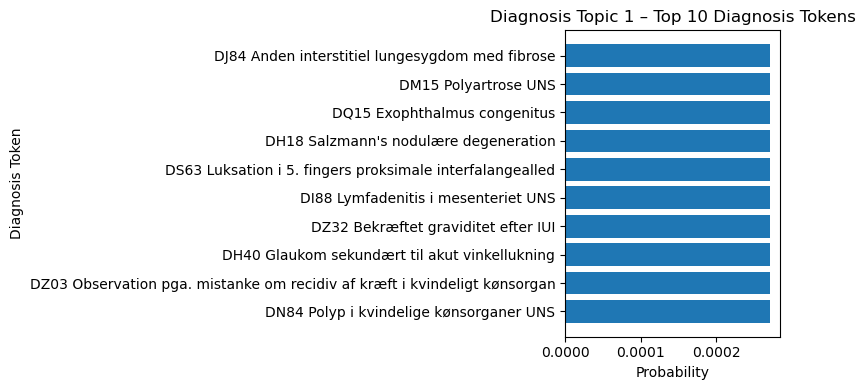

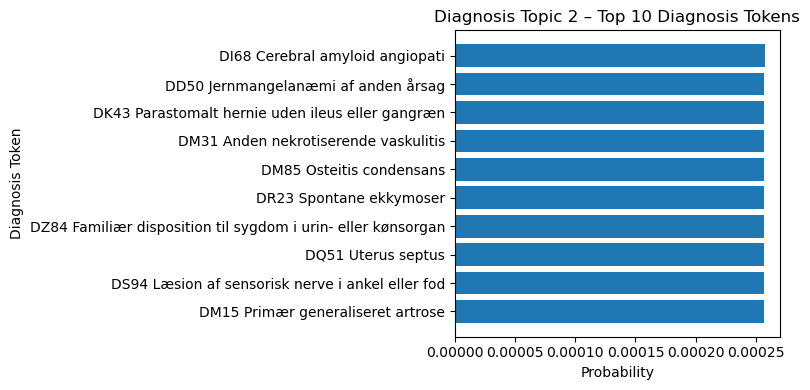

In [27]:
num_topics_to_plot = 3

inv_diag_vocab = {idx: token for token, idx in diag_vocab.items()}
for i in range(num_topics_to_plot):
    plot_top_tokens(phi_x, inv_diag_vocab, topic_idx=i, top_k=10,
                    title_prefix="Diagnosis Topic", label="Diagnosis Token")

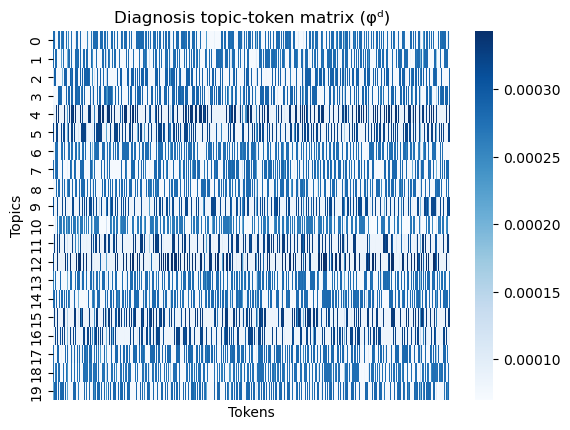

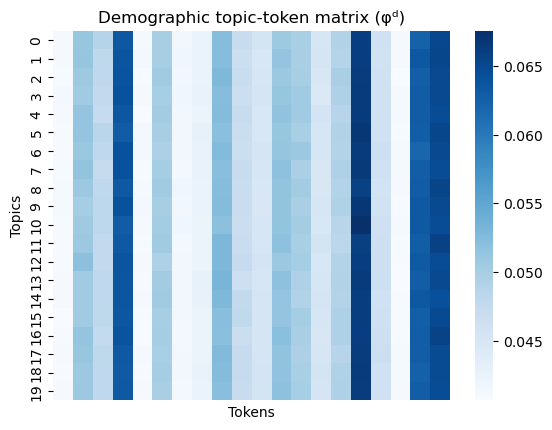

In [ ]:

sns.heatmap(phi_x.cpu().detach().numpy(), cmap="Blues", xticklabels=False)
plt.title("Diagnosis topic-token matrix (φᵈ)")
plt.xlabel("Tokens")
plt.ylabel("Topics")
plt.show()

sns.heatmap(phi_d.cpu().detach().numpy(), cmap="Blues", xticklabels=False)
plt.title("Demographic topic-token matrix (φᵈ)")
plt.xlabel("Tokens")
plt.ylabel("Topics")
plt.show()

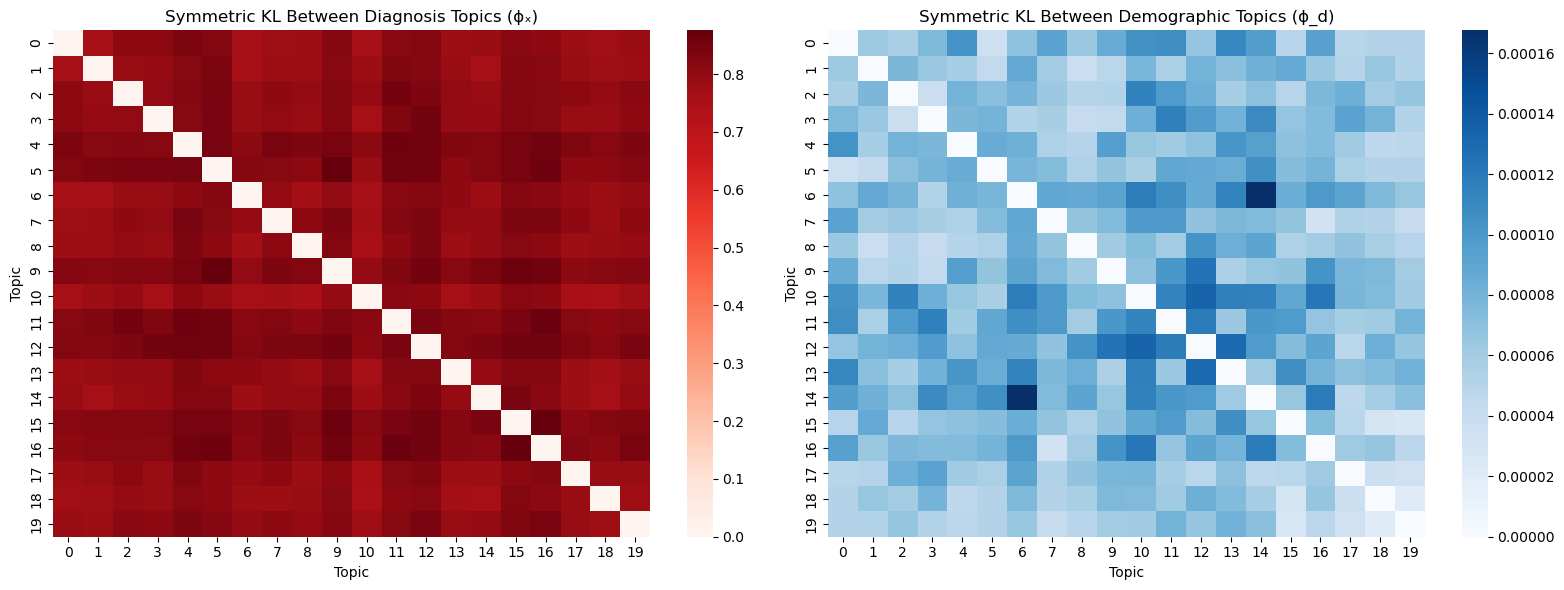

In [ ]:
import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

# --- Helper: Symmetric KL Divergence ---
def symmetric_kl(p, q, eps=1e-10):
    p = torch.clamp(p, min=eps)
    q = torch.clamp(q, min=eps)
    p = p / p.sum()
    q = q / q.sum()
    kl_pq = torch.sum(p * torch.log(p / q))
    kl_qp = torch.sum(q * torch.log(q / p))
    return (kl_pq + kl_qp).item()

# --- Extract phi_x and phi_d ---
phi_x = pyro.param("phi_x_posterior").detach().cpu()  # shape: [num_topics, num_diag_tokens]
phi_d = pyro.param("phi_d_posterior").detach().cpu()  # shape: [num_topics, num_demo_tokens]

num_topics = phi_x.shape[0]

# --- Compute Symmetric KL Matrices ---
kl_matrix_x = torch.zeros(num_topics, num_topics)
kl_matrix_d = torch.zeros(num_topics, num_topics)

for i in range(num_topics):
    for j in range(num_topics):
        kl_matrix_x[i, j] = symmetric_kl(phi_x[i], phi_x[j])
        kl_matrix_d[i, j] = symmetric_kl(phi_d[i], phi_d[j])

# --- Plot Heatmaps ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(kl_matrix_x.numpy(), ax=axs[0], cmap="Reds", cbar=True)
axs[0].set_title("Symmetric KL Between Diagnosis Topics (ϕₓ)")
axs[0].set_xlabel("Topic")
axs[0].set_ylabel("Topic")

sns.heatmap(kl_matrix_d.numpy(), ax=axs[1], cmap="Blues", cbar=True)
axs[1].set_title("Symmetric KL Between Demographic Topics (ϕ_d)")
axs[1].set_xlabel("Topic")
axs[1].set_ylabel("Topic")

plt.tight_layout()
plt.show()



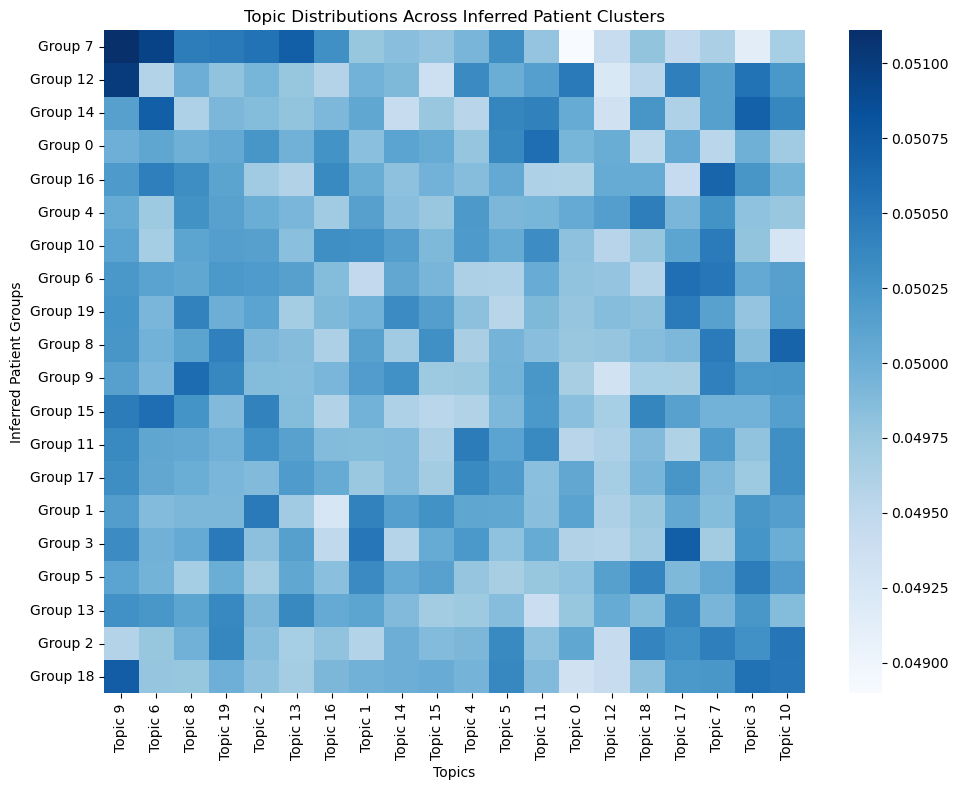

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist

# --- Assume `heatmap_data` is [num_groups, num_topics] matrix already computed ---

# Hierarchical clustering to reorder rows and columns
row_linkage = linkage(pdist(heatmap_data, metric="euclidean"), method="average")
col_linkage = linkage(pdist(heatmap_data.T, metric="euclidean"), method="average")

row_order = leaves_list(row_linkage)
col_order = leaves_list(col_linkage)

# Reorder the matrix
reordered = heatmap_data[row_order][:, col_order]

# Plot without dendrograms
plt.figure(figsize=(10, 8))
sns.heatmap(reordered, cmap="Blues", cbar=True,
            xticklabels=[f"Topic {i}" for i in col_order],
            yticklabels=[f"Group {i}" for i in row_order])
plt.title("Topic Distributions Across Inferred Patient Clusters")
plt.xlabel("Topics")
plt.ylabel("Inferred Patient Groups")
plt.tight_layout()
plt.show()

